# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [1]:
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

**Reviews**

In [2]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1


In [4]:
data_reviews = pd.DataFrame(data_reviews)

In [5]:
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396844,NaN,NaN


In [6]:
data_reviews.shape

(779307, 12)

In [7]:
data_reviews.isna().sum()

username             0
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text                 0
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

**Games**

In [8]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [9]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [10]:
data_games.shape

(32135, 16)

#### Cantidad de usuarios

In [11]:
print(len(data_reviews['username'].unique()))

540341


#### Cantidad de juegos 

In [12]:
print(len(data_reviews['product_id'].unique()))

12665


#### Cuál es el juego más jugado?

In [13]:
max_hs = data_reviews['hours'].max()
product_id_max_hs = data_reviews['product_id'][data_reviews['hours'] == max_hs]
#str(int(product_id_max_hs))
data_games[data_games['id'] == str(int(product_id_max_hs))]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
28926,"Trion Worlds, Inc.","[Action, Free to Play, Massively Multiplayer, ...",Defiance,Defiance,http://store.steampowered.com/app/224600/Defia...,2014-06-04,"[Free to Play, Action, Open World, Massively M...",NaN,http://steamcommunity.com/app/224600/reviews/?...,"[Multi-player, MMO, Co-op, Steam Trading Cards...",Free to Play,False,224600,"Trion Worlds, Inc.",Mostly Positive,64


#### Cuáles son los juegos menos jugados?

In [14]:
min_hs = data_reviews['hours'].min()
product_id_min_hs = data_reviews[data_reviews['hours'] == min_hs]
product_id_min_hs['product_id'].sort_values(ascending = False)

201528    99910
117611    99700
264206    98100
444514    95700
601303    94590
          ...  
698334    10180
696574    10180
698766    10180
696592    10180
700024    10180
Name: product_id, Length: 459, dtype: object

In [15]:
data_games[data_games['id'].isin(product_id_min_hs['product_id'])].sort_values(by = 'id', ascending = False)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
720,Three Rings,"[Adventure, Casual, Free to Play, Massively Mu...",Puzzle Pirates,Puzzle Pirates,http://store.steampowered.com/app/99910/Puzzle...,2011-08-31,"[Free to Play, Massively Multiplayer, Puzzle, ...",NaN,http://steamcommunity.com/app/99910/reviews/?b...,"[Single-player, Multi-player, MMO, Co-op, Stea...",Free to Play,False,99910,Three Rings,Very Positive,NaN
31281,"Nicalis, Inc.","[Casual, Indie, Strategy]",NightSky,NightSky,http://store.steampowered.com/app/99700/NightSky/,2011-03-01,"[Indie, Platformer, Casual, Puzzle, Physics, A...",NaN,http://steamcommunity.com/app/99700/reviews/?b...,[Single-player],9.99,False,99700,"Nicalis, Inc.",Very Positive,78
31220,Krystian Majewski,"[Adventure, Indie, Casual]",Trauma,Trauma,http://store.steampowered.com/app/98100/Trauma/,2011-08-08,"[Indie, Adventure, Casual, Point & Click, Expe...",NaN,http://steamcommunity.com/app/98100/reviews/?b...,[Single-player],6.99,False,98100,Krystian Majewski,Mostly Positive,62
659,Peter Brinson and Kurosh ValaNejad,[Indie],The Cat and the Coup,The Cat and the Coup,http://store.steampowered.com/app/95700/The_Ca...,2011-06-15,"[Indie, Historical, Free to Play, Puzzle, Shor...",NaN,http://steamcommunity.com/app/95700/reviews/?b...,[Single-player],Free,False,95700,Peter Brinson and Kurosh ValaNejad,Very Positive,NaN
685,Telltale Games,"[Adventure, Casual]",Puzzle Agent 2,Puzzle Agent 2,http://store.steampowered.com/app/94590/Puzzle...,2011-06-30,"[Puzzle, Adventure, Point & Click, Casual, Det...",NaN,http://steamcommunity.com/app/94590/reviews/?b...,"[Single-player, Steam Achievements]",9.99,False,94590,Telltale Games,Very Positive,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860,Remedy Entertainment,"[Action, Adventure]",Alan Wake,Alan Wake,http://store.steampowered.com/app/108710/Alan_...,2012-02-16,"[Action, Horror, Adventure, Third Person, Stor...",NaN,http://steamcommunity.com/app/108710/reviews/?...,"[Single-player, Steam Achievements, Full contr...",9.99,False,108710,Remedy Entertainment,Very Positive,83
31031,Uber Entertainment,"[Free to Play, Action, Strategy, Indie, Sports]",Super MNC,Super MNC,http://store.steampowered.com/app/104700/Super...,2012-04-19,"[Free to Play, Action, Multiplayer, MOBA, Shoo...",NaN,http://steamcommunity.com/app/104700/reviews/?...,"[Multi-player, Partial Controller Support, Sta...",Free to Play,False,104700,Uber Entertainment,Mixed,76
653,En Masse Entertainment,"[Action, Free to Play]",A.V.A. Alliance of Valiant Arms™,A.V.A. Alliance of Valiant Arms™,http://store.steampowered.com/app/102700/AVA_A...,2011-06-14,"[Free to Play, FPS, Action, Multiplayer, Shoot...",NaN,http://steamcommunity.com/app/102700/reviews/?...,"[Multi-player, Online Multi-Player, Co-op, Onl...",Free to Play,False,102700,Red Duck Inc.,Mixed,NaN
31148,Robot Entertainment,"[Action, Indie, Strategy]",Orcs Must Die!,Orcs Must Die!,http://store.steampowered.com/app/102600/Orcs_...,2011-10-11,"[Tower Defense, Action, Strategy, Third Person...",NaN,http://steamcommunity.com/app/102600/reviews/?...,"[Single-player, Steam Achievements, Partial Co...",9.99,False,102600,Robot Entertainment,Overwhelmingly Positive,83


#### Armo un Dataframe con los datos que me interesan: Usuario, hours, el id del juego y el título del juego

In [16]:
data1 = data_reviews.copy()
data1.drop(['products', 'page_order', 'date', 'text', 'early_access', 'page', 'user_id', 'compensation', 'found_funny'], axis=1, inplace = True)
data1.rename({'hours': 'rating_hs'}, axis = 'columns', inplace = True)
data = data1.merge(data_games, how='inner', left_on='product_id', right_on='id')
data.drop(['publisher', 'genres', 'app_name', 'url', 'release_date', 'tags', 'discount_price', 'reviews_url', 'specs', 'price', 'early_access', 'id', 'developer', 'sentiment', 'metascore'], axis = 1, inplace = True)
print(data.shape, data1.shape)
data.head()

(779951, 4) (779307, 3)


,username,rating_hs,product_id,title
0,Chaos Syren,0.1,725280,Psi Project
1,freakfantom,0.1,725280,Psi Project
2,Ariman1,13.2,328100,Gunspell - Steam Edition
3,dll3z,0.4,328100,Gunspell - Steam Edition
4,Nyazicat,2.2,328100,Gunspell - Steam Edition


#### Armo el rating a partir de la variable 'hours'

In [17]:
data_reviews['hours'].describe()

count    776670.000000
mean        111.843832
std         390.145376
min           0.000000
25%           4.000000
50%          15.300000
75%          59.600000
max       28164.000000
Name: hours, dtype: float64

In [18]:
#Armo los rangos teniendo en cuenta los cuartiles, desde 0 al cuartil 50 o media, el rating es 1, entre el cuartil
#50 y el 75 es 1, y a partir del 75 hacia el maximo es 3
bins = [0, 15.3, 60, 28165]
labels = [1,2,3]
data['rating_hs'] = pd.cut(data_reviews['hours'], bins, labels = labels)

In [19]:
data.groupby(['rating_hs']).size()

rating_hs
1    388142
2    194727
3    193342
dtype: int64

In [20]:
#Voy a filtrar por aquellos juegos que hayan sido clasificados como mínimo 3 veces
games_3 = data.groupby(['product_id']).size()
games_3 = games_3[games_3 >= 3]
print('La cantidad de juegos que han sido jugados como mínimo 3 veces son: ',len(games_3))

La cantidad de juegos que han sido jugados como mínimo 3 veces son:  8511


In [21]:
#Me quedo con los juegos que han sido jugados minimo 3 veces
data = data[data['product_id'].isin(games_3.index)]

In [22]:
#Elimino los vares Nan 
data.isna().sum()
data.dropna(inplace = True)

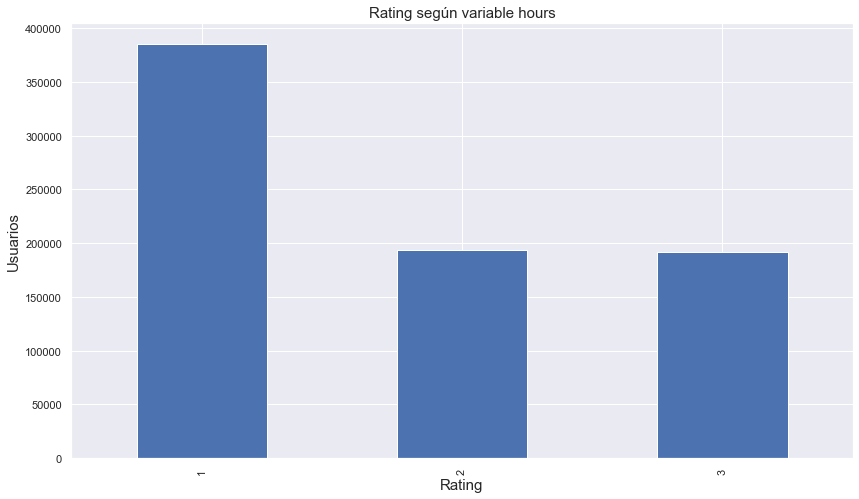

In [23]:
plt.figure(figsize = (14,8))
data.groupby(['rating_hs']).size().plot(kind = 'bar')
plt. xlabel('Rating', fontsize=15) 
plt. ylabel('Usuarios', fontsize=15)
plt.title('Rating según variable hours', fontsize = 15)
plt.show()

#### Juegos con mayor rating

In [24]:
data.head()

,username,rating_hs,product_id,title
2,Ariman1,1,328100,Gunspell - Steam Edition
3,dll3z,1,328100,Gunspell - Steam Edition
4,Nyazicat,1,328100,Gunspell - Steam Edition
5,novocain,1,328100,Gunspell - Steam Edition
6,raixel,1,328100,Gunspell - Steam Edition


In [25]:
data.sort_values(by = 'rating_hs', ascending = False).head(10)

,username,rating_hs,product_id,title
389534,[HSOWA]NINJA,3,51100,Tactical Intervention
376613,mosekvist™,3,440,Team Fortress 2
376611,SHOBOBINVANJIN,3,440,Team Fortress 2
376609,([GG]),3,440,Team Fortress 2
376608,bittomcat115,3,440,Team Fortress 2
376607,Soft,3,440,Team Fortress 2
376605,Theflyingpizza,3,440,Team Fortress 2
376604,Master of Puppets,3,440,Team Fortress 2
376603,mosekvist™,3,440,Team Fortress 2
376602,Kanna-San,3,440,Team Fortress 2


#### Creo el modelo 

In [26]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy

In [27]:
reader = Reader()

In [28]:
data = Dataset.load_from_df(data[['username', 'product_id', 'rating_hs']], reader)

In [29]:
trainset, testset = train_test_split(data, test_size=.25)

In [91]:
##Entrenamiento del modelo

In [30]:
algo = SVD()

In [31]:
algo.fit(trainset) #Con esta linea el modelo algo esta descomponiendo la matriz U y V 

In [32]:
predictions = algo.test(testset)

In [33]:
predictions[10]

Prediction(uid='Bïtë', iid='301520', r_ui=1.0, est=1.7015234503030485, details={'was_impossible': False})

En el resultado de predicción, uid representa la identificación del usuario, iid representa la identificación de la película, r_ui representa la calificación real de la película del usuario y est representa la calificación predicha por el algoritmo SVD.

In [34]:
RMSE_hs = accuracy.rmse(predictions)

RMSE: 0.7938


In [97]:
#El erorr RMSE de 0,79 indica que el modelo se está equivocando en 0,79 unidades de rating

#### Armo el rating pero a partir de la variable sentiment

In [36]:
data_aux = data_reviews.copy()
data_aux.drop(['products','hours', 'page_order', 'date', 'text', 'early_access', 'page', 'user_id', 'compensation', 'found_funny'], axis=1, inplace = True)
data2 = data_aux.merge(data_games, how='inner', left_on='product_id', right_on='id')
data2.drop(['publisher', 'genres', 'app_name', 'url', 'release_date', 'tags', 'discount_price', 'reviews_url', 'specs', 'price', 'early_access', 'id', 'developer', 'metascore'], axis = 1, inplace = True)
print(data2.shape, data_aux.shape)
data2.head()

(779951, 4) (779307, 2)


,username,product_id,title,sentiment
0,Chaos Syren,725280,Psi Project,Positive
1,freakfantom,725280,Psi Project,Positive
2,Ariman1,328100,Gunspell - Steam Edition,Mixed
3,dll3z,328100,Gunspell - Steam Edition,Mixed
4,Nyazicat,328100,Gunspell - Steam Edition,Mixed


In [37]:
#Me quedo con los juegos que han sido jugados minimo 3 veces
data2 = data2[data2['product_id'].isin(games_3.index)]

In [38]:
data2.dropna(inplace = True)
data2.isna().sum()

username      0
product_id    0
title         0
sentiment     0
dtype: int64

#### Usando la libreria TextBlob convierto la variable sentiments a valores numericos entre -1 y 1 que corresponden a si ese sentimiento fue positivo o negativo con respecto al juego

In [39]:
from textblob import TextBlob

def sentimientos(x):
    return TextBlob(x).sentiment.polarity


data2['polarity'] = data2['sentiment'].apply(sentimientos)

In [40]:
data2.sentiment.unique()

array(['Mixed', 'Positive', 'Overwhelmingly Positive', 'Very Positive',
       'Mostly Positive', 'Mostly Negative', 'Very Negative',
       '3 user reviews', '4 user reviews', '9 user reviews',
       '5 user reviews', '2 user reviews', 'Negative', '6 user reviews',
       '8 user reviews', '7 user reviews', '1 user reviews',
       'Overwhelmingly Negative'], dtype=object)

In [41]:
data2.polarity.unique()

array([ 0.        ,  0.22727273,  0.29545455, -0.3       , -0.39      ])

In [42]:
data2['rating_sent'] = data2['polarity']

In [43]:
#Armo el rating 1,2 o 3 teniendo en cuenta los valores que obtuve de polaridad segun los sentimientos 
data2['rating_sent'][data2['polarity'] < -0.2] = 1
data2['rating_sent'][(data2['polarity'] > -0.2) & (data2['polarity'] < 0.2)] = 2
data2['rating_sent'][data2['polarity'] > 0.2] = 3

<ipython-input-43-55522e7878a6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['rating_sent'][data2['polarity'] < -0.2] = 1
<ipython-input-43-55522e7878a6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['rating_sent'][(data2['polarity'] > -0.2) & (data2['polarity'] < 0.2)] = 2
<ipython-input-43-55522e7878a6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['rating_sent'][data2['polarity'] > 0.2] = 3


In [44]:
data2.head()

,username,product_id,title,sentiment,polarity,rating_sent
2,Ariman1,328100,Gunspell - Steam Edition,Mixed,0.0,2.0
3,dll3z,328100,Gunspell - Steam Edition,Mixed,0.0,2.0
4,Nyazicat,328100,Gunspell - Steam Edition,Mixed,0.0,2.0
5,novocain,328100,Gunspell - Steam Edition,Mixed,0.0,2.0
6,raixel,328100,Gunspell - Steam Edition,Mixed,0.0,2.0


In [45]:
data2.groupby(['rating_sent']).size()

rating_sent
1.0      9312
2.0    120535
3.0    644422
dtype: int64

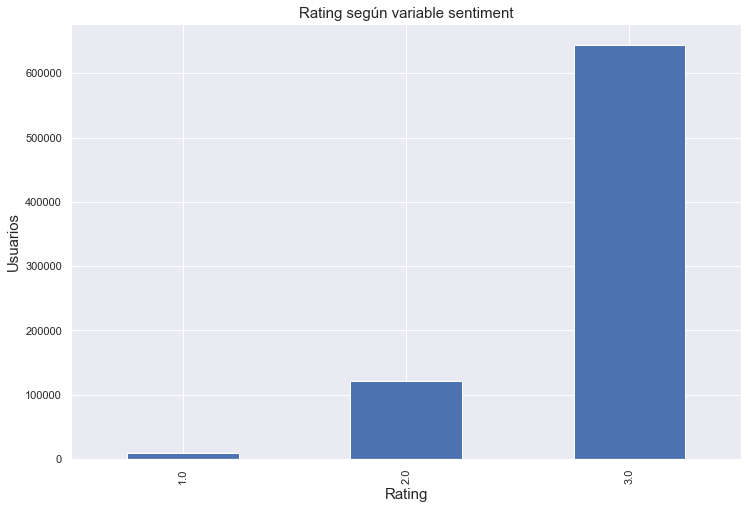

In [46]:
plt.figure(figsize = (12,8))
data2.groupby(['rating_sent']).size().plot(kind = 'bar')
plt. xlabel('Rating', fontsize=15) 
plt. ylabel('Usuarios', fontsize=15) 
plt.title('Rating según variable sentiment', fontsize = 15)
plt.show()

In [47]:
data2.head()

,username,product_id,title,sentiment,polarity,rating_sent
2,Ariman1,328100,Gunspell - Steam Edition,Mixed,0.0,2.0
3,dll3z,328100,Gunspell - Steam Edition,Mixed,0.0,2.0
4,Nyazicat,328100,Gunspell - Steam Edition,Mixed,0.0,2.0
5,novocain,328100,Gunspell - Steam Edition,Mixed,0.0,2.0
6,raixel,328100,Gunspell - Steam Edition,Mixed,0.0,2.0


#### Creo el modelo

In [48]:
data2_aux = Dataset.load_from_df(data2[['username', 'product_id', 'rating_sent']], reader)
trainset, testset = train_test_split(data2_aux, test_size=.25)

In [49]:
##Entrenamiento del modelo
algo = SVD()
algo.fit(trainset) #Con esta linea el modelo algo esta descomponiendo la matriz U y V 

In [51]:
predictions_sent = algo.test(testset)

len(predictions_sent)

193568

In [52]:
RMSE_svd = accuracy.rmse(predictions_sent)

RMSE: 0.1077


In [ ]:
#El erorr RMSE de 0.1 indica que el modelo se está equivocando en 0.1 unidades de rating

In [40]:
def Extract(lst):
    return [round(item[3],2) for item in lst]

### Usando el rating basado en los sentimientos, que es con el que menor error obtuve, pruebo otros modelos y los comparo

#### Modelo SVD ++, es  una extensión del modelo SVD pero tiene en cuenta los rating implícitos 

In [53]:
from surprise import SVDpp

In [54]:
algo = SVDpp()
algo.fit(trainset) 
predictions_svdpp = algo.test(testset)
predictions_svdpp[10] 
RMSE_svdpp = accuracy.rmse(predictions_svdpp)

RMSE: 0.1035


#### Modelo Non negative Matrix Factorization (NMF)

In [55]:
from surprise import NMF

In [56]:
algo = NMF()
algo.fit(trainset)  
predictions_nmf = algo.test(testset)
predictions_nmf[10]
RMSE_nmf = accuracy.rmse(predictions_nmf)

RMSE: 0.3675


#### Modelo Co-Clustering 

In [57]:
from surprise import CoClustering

In [58]:
algo = CoClustering()
algo.fit(trainset)  
predictions_coclustering = algo.test(testset)
predictions_coclustering[10]
RMSE_coclustering = accuracy.rmse(predictions_coclustering)

<ipython-input-58-e23f4047a7be>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo.fit(trainset)


RMSE: 0.3748


#### Modelo SlopeOne

In [60]:
from surprise import SlopeOne

In [61]:
algo = SlopeOne()
algo.fit(trainset)  
predictions_slopeone = algo.test(testset)
predictions_slopeone[10]
RMSE_slopeone = accuracy.rmse(predictions_slopeone)

<ipython-input-61-b4ad25957ccb>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo.fit(trainset)


RMSE: 0.3988


#### Modelo BaselineOlny  usando el método  Alternating Least Squares (ALS)

In [63]:
from surprise import BaselineOnly

In [67]:
algo = BaselineOnly(bsl_options = {'method': 'als'})
algo.fit(trainset)  
predictions_als = algo.test(testset)
predictions_als[10]
RMSE_als = accuracy.rmse(predictions_als)

Estimating biases using als...
RMSE: 0.1135


### Comparo los modelos con el error obtenido en cada uno de ellos 

In [68]:
errores = [RMSE_svd, RMSE_svdpp, RMSE_nmf, RMSE_coclustering, RMSE_slopeone, RMSE_als]
labels = ['SVD', 'SVD ++', 'NMF', 'Co - Clustering', 'Slope One', 'ALS']

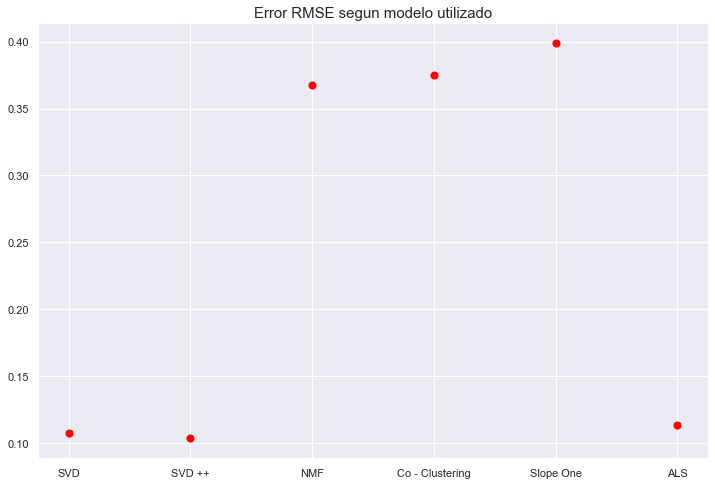

In [69]:
plt.figure(figsize = (12,8))
plt.scatter(x = labels, y = errores, s = 50, color = 'red')
plt.title('Error RMSE segun modelo utilizado', fontsize = 15)
plt.show()

####  El menor error lo obtuve con el modelo SVD ++, por lo cual voy a optimizar los hiperparametros de ese modelo

In [70]:
algo = SVDpp()
algo.fit(trainset) 
predictions_svdpp = algo.test(testset)

In [72]:
from surprise.model_selection import GridSearchCV
factores = [10, 20, 30, 50, 100, 200, 500]

param_grid = {'n_factors': factores}
gs4 = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs4.fit(data2_aux)

In [73]:
RMSE_svdpp_grid = gs4.best_score['rmse']
print(RMSE_svdpp_grid)
print(gs4.best_params['rmse'])

0.10256755757144542
{'n_factors': 10}


#### Para darle una utilidad al modelo de recomendación, creo una función que recibe nombre de usuario y la cantidad de recomendaciones que quiere recibir,  y devuelve una tabla con la cantidad de recomendaciones solicitadas 

In [74]:
def recomendaciones(usuario, N):
    
    #Estos son los juegos que jugó
    usuario_jugados = data2[data2['username'] == usuario].copy()
        
    #Armo el dataframe que devolverá la función y elimino los juegos que el usuario ya jugó
    recomendaciones_usuario = data2.drop(['username', 'sentiment', 'polarity', 'rating_sent'], axis = 1).copy()
    recomendaciones_usuario['product_id'][~recomendaciones_usuario['product_id'].isin(usuario_jugados['product_id'])]
    recomendaciones_usuario.reset_index(drop = True, inplace = True)
    
    #Estimaciones del modelo
    recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: algo.predict(usuario, x).est)
    recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
    recomendaciones_usuario.drop_duplicates(inplace = True)
    recomendaciones_usuario.reset_index(drop = True, inplace = True)
    
    return recomendaciones_usuario.head(N)

In [75]:
recomendaciones('raixel', 4)

,product_id,title,Estimate_Score
0,425210,Shadwen,3.110440
1,509220,Save Jesus,3.089922
2,245450,Wizardry 8,3.069386
3,1930,Two Worlds Epic Edition,3.062918
